# MSiA 431 Final Project

# Image Classification and Style-Transfer




In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from keras import applications
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Activation, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from skimage.exposure import equalize_hist
from skimage import data, io, filters, color, exposure
from PIL import Image
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

### Resizing
Output size: (128, 128, 3)

The code defines a function called resize_images that resizes images in an input folder to a specified target size and saves them in an output folder. It uses the os library to handle file operations and the PIL library for image processing. The function checks if the output folder exists and creates it if necessary. It iterates over the files in the input folder, skipping non-image files. For each image file, it opens the image, resizes it to the target size (128, 128, 3), and saves the resized image in the output folder. The code provides an example usage to demonstrate how to resize images.

See details in [this notebook](https://drive.google.com/file/d/1-FXdz42jF393b1Q4WEe24TPugwSk7gTz/view?usp=sharing).

### Intensity Equalization

In [ ]:
# Define a function to equalize the histogram of an image
def equalize_histogram(img):
    # Convert to 8-bit integer format and scale to the range of 0-255
    equalized_img = equalize_hist(img)

    return equalized_img

In [ ]:
# Define the directory containing the images to be equalized
dir_path = '/content/drive/MyDrive/Spring 2023/MSiA432_DL_project/data/resize_data/'

# Define the directory to save the equalized images
save_dir_path = '/content/drive/MyDrive/Spring 2023/MSiA432_DL_project/data/equalized_data/'

# Iterate over all the image files in the directory
for folder in os.listdir(dir_path):
  folder_path = os.path.join(dir_path, folder)
  for file_name in os.listdir(folder_path):
    # Check if the file is an image file
    if file_name.endswith('.jpg') or file_name.endswith('.jpeg') or file_name.endswith('.png'):
        # Load the image
        img = mpimg.imread(os.path.join(folder_path, file_name))

        # Equalize the histogram of the image
        equalized_img = equalize_histogram(img)

        # Save the equalized image to a new file
        save_file_name = os.path.join(save_dir_path, folder, file_name)
        plt.imsave(save_file_name, equalized_img)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


### Train-Test Split

In [ ]:
# Add label to file path
def preprocess(folder_path):
  file_path = []
  labels = []

  for folder in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path,folder)):
      classpath = os.path.join(folder_path,folder)
      flist = os.listdir(classpath)
      for f in flist:
        fpath = os.path.join(classpath,f)
        file_path.append(fpath)
        labels.append(folder)

  Fseries = pd.Series(file_path, name='filepaths')
  Lseries = pd.Series(labels, name='labels')
  df = pd.concat([Fseries, Lseries], axis=1)
  return df

In [ ]:
# Read images paths and build a dataframe on paths and labels
sdir = '/content/drive/MyDrive/Spring 2023/MSiA432_DL_project/data/equalized_data'
df = preprocess(sdir)
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=df['labels'])

In [ ]:
test_df.head(5)

,filepaths,labels
304,/content/drive/MyDrive/Spring 2023/MSiA432_DL_...,leopard
346,/content/drive/MyDrive/Spring 2023/MSiA432_DL_...,leopard
313,/content/drive/MyDrive/Spring 2023/MSiA432_DL_...,leopard
262,/content/drive/MyDrive/Spring 2023/MSiA432_DL_...,panda
460,/content/drive/MyDrive/Spring 2023/MSiA432_DL_...,hamster


In [ ]:
# Define a function to load and preprocess an image
def load_image(image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')  # Convert image to RGB format
    img_array = np.array(img)  # Convert image to a NumPy array
    img.close()
    return img_array

# Define lists to store the image data and labels
test_images = []
test_labels = []

# Loop through your image paths and labels
for image_path, label in zip(test_df.filepaths.to_list(), test_df.labels.to_list()):
    img_array = load_image(image_path)
    test_images.append(img_array)
    test_labels.append(label)

# Convert the lists to NumPy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)


In [ ]:
test_images.shape

(120,)

In [ ]:
# Define lists to store the image data and labels
train_images = []
train_labels = []

# Loop through your image paths and labels
for image_path, label in zip(train_df.filepaths.to_list(), train_df.labels.to_list()):
    img_array = load_image(image_path)
    train_images.append(img_array)
    train_labels.append(label)

# Convert the lists to NumPy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
train_images.shape

(480, 128, 128, 3)

In [ ]:
# Save artifact
out_dir = "/content/drive/MyDrive/Spring 2023/MSiA432_DL_project/data/train_test_data/"

with open(f"{out_dir}train_images.pkl", "wb") as f:
  pickle.dump(train_images, f)

with open(f"{out_dir}train_labels.pkl", "wb") as f:
  pickle.dump(train_labels, f)

with open(f"{out_dir}test_images.pkl", "wb") as f:
  pickle.dump(test_images, f)

with open(f"{out_dir}test_labels.pkl", "wb") as f:
  pickle.dump(test_labels, f)

# EDA

## Color Histogram - Original images

### Example 1 - Bear

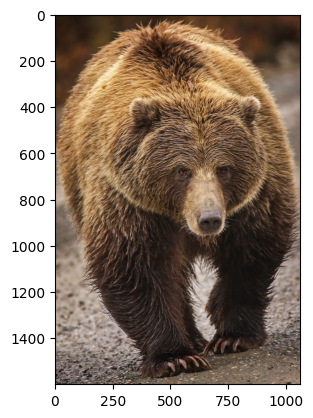

In [ ]:
#read image from disk
filename = '/content/drive/MyDrive/Spring 2023/MSiA432_DL_project/data/original_data/bear/039b2ae790.jpg'
bear = io.imread(filename)
plt.imshow(bear)

Text(0.5, 1.0, 'Chelsea Histogram (Bear)')

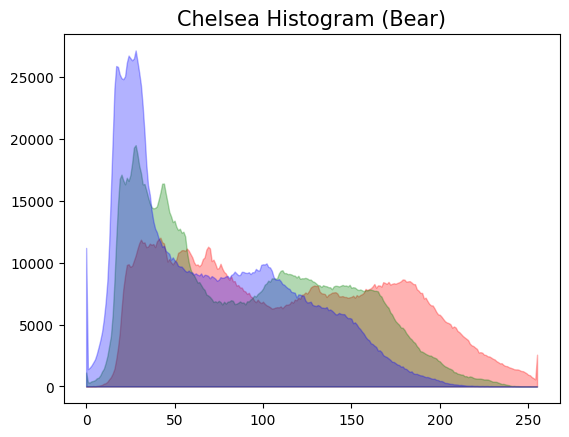

In [ ]:
#plot histogram
for col, channel in zip('rgb', np.rollaxis(bear, axis=-1)):
    hist, bin_centers = exposure.histogram(channel)
    plt.fill_between(bin_centers, hist, color=col, alpha=0.3)
plt.title('Color Histogram (Bear)', fontsize=15)

### Example 2 - Crab

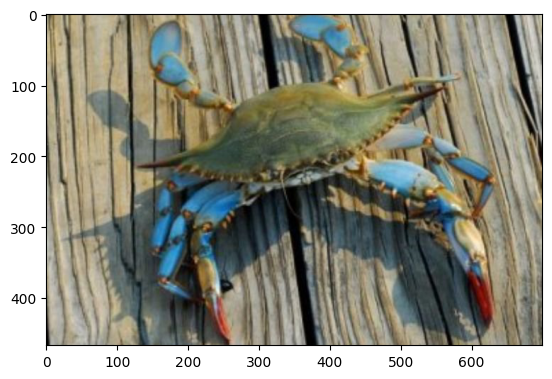

In [ ]:
#read image from disk
filename = '/content/drive/MyDrive/Spring 2023/MSiA432_DL_project/data/original_data/crab/03a4208397.jpg'
crab = io.imread(filename)
plt.imshow(crab)

Text(0.5, 1.0, 'Chelsea Histogram (Crab)')

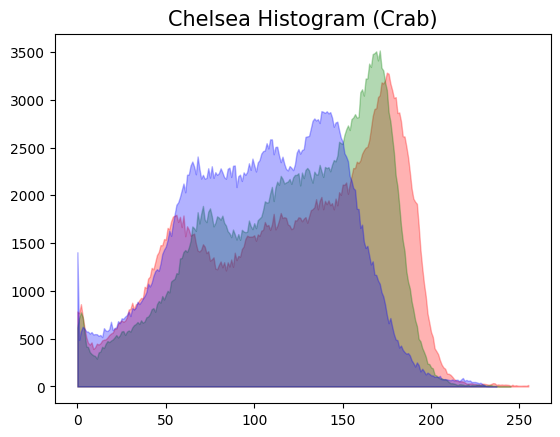

In [ ]:
#plot histogram
for col, channel in zip('rgb', np.rollaxis(crab, axis=-1)):
    hist, bin_centers = exposure.histogram(channel)
    plt.fill_between(bin_centers, hist, color=col, alpha=0.3)
plt.title('Color Histogram (Crab)', fontsize=15)

### Example 3 - Duck

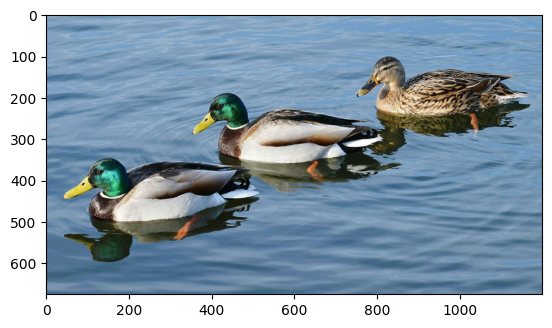

In [ ]:
#read image from disk
filename = '/content/drive/MyDrive/Spring 2023/MSiA432_DL_project/data/original_data/duck/25e76d5a00.jpg'
duck = io.imread(filename)
plt.imshow(duck)

Text(0.5, 1.0, 'Chelsea Histogram (Duck)')

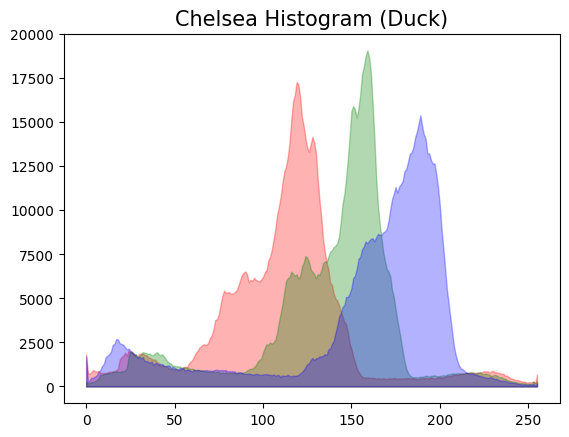

In [ ]:
#plot histogram
for col, channel in zip('rgb', np.rollaxis(duck, axis=-1)):
    hist, bin_centers = exposure.histogram(channel)
    plt.fill_between(bin_centers, hist, color=col, alpha=0.3)
plt.title('Color Histogram (Duck)', fontsize=15)

## Color Histogram - Images after resizing and intensity equalization

### Example 1 - Bear

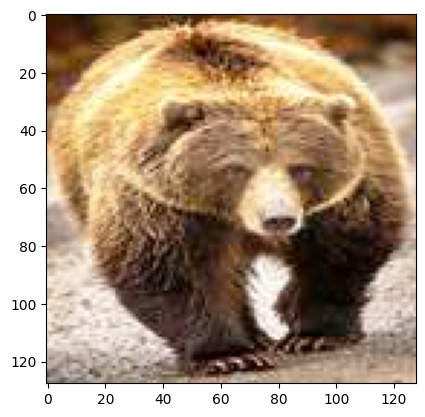

In [ ]:
#read image from disk
filename = '/content/drive/MyDrive/Spring 2023/MSiA432_DL_project/data/equalized_data/bear/039b2ae790.jpg'
bear_eq = io.imread(filename)
plt.imshow(bear_eq)

Text(0.5, 1.0, 'Chelsea Histogram (Bear; Resized and Equalized Intensity)')

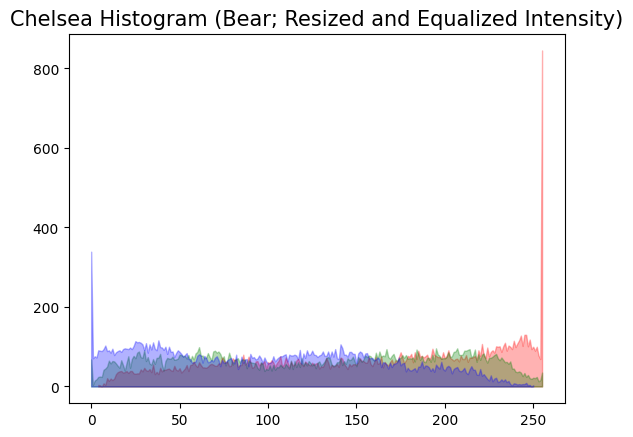

In [ ]:
#plot histogram
for col, channel in zip('rgb', np.rollaxis(bear_eq, axis=-1)):
    hist, bin_centers = exposure.histogram(channel)
    plt.fill_between(bin_centers, hist, color=col, alpha=0.3)
plt.title('Color Histogram (Bear; Resized and Equalized Intensity)', fontsize=15)

### Example 2 - Crab

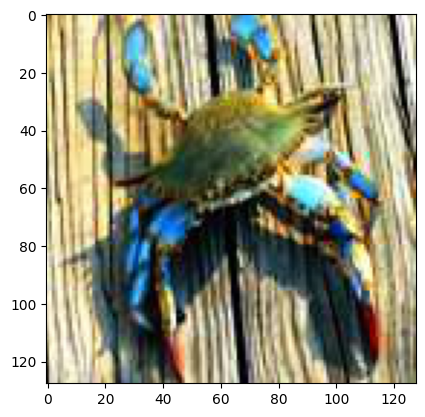

In [ ]:
#read image from disk
filename = '/content/drive/MyDrive/Spring 2023/MSiA432_DL_project/data/equalized_data/crab/03a4208397.jpg'
crab_eq = io.imread(filename)
plt.imshow(crab_eq)

Text(0.5, 1.0, 'Chelsea Histogram (Crab; Resized and Equalized Intensity)')

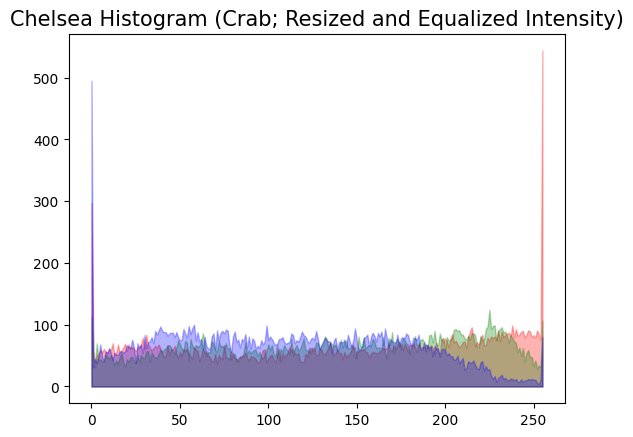

In [ ]:
#plot histogram
for col, channel in zip('rgb', np.rollaxis(crab_eq, axis=-1)):
    hist, bin_centers = exposure.histogram(channel)
    plt.fill_between(bin_centers, hist, color=col, alpha=0.3)
plt.title('Color Histogram (Crab; Resized and Equalized Intensity)', fontsize=15)

### Example 3 - Duck

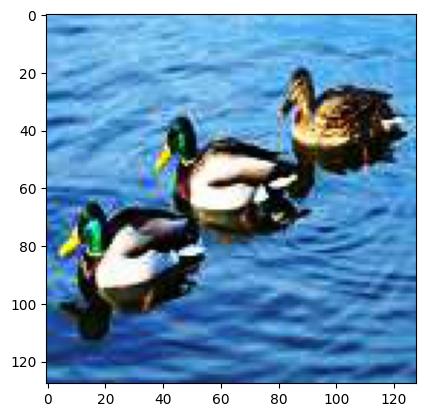

In [ ]:
#read image from disk
filename = '/content/drive/MyDrive/Spring 2023/MSiA432_DL_project/data/equalized_data/duck/25e76d5a00.jpg'
duck_eq = io.imread(filename)
plt.imshow(duck_eq)

Text(0.5, 1.0, 'Chelsea Histogram (Duck; Resized and Equalized Intensity)')

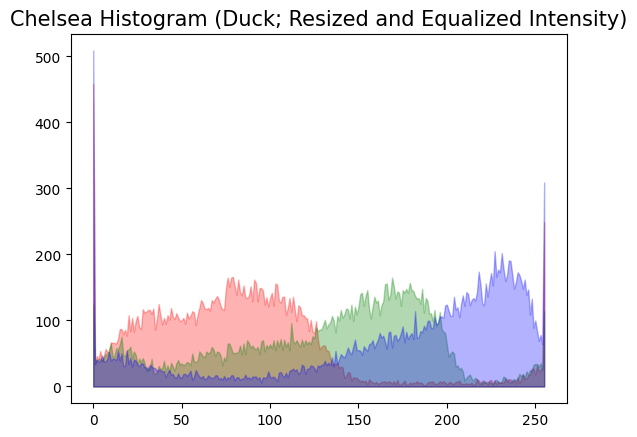

In [ ]:
#plot histogram
for col, channel in zip('rgb', np.rollaxis(duck_eq, axis=-1)):
    hist, bin_centers = exposure.histogram(channel)
    plt.fill_between(bin_centers, hist, color=col, alpha=0.3)
plt.title('Color Histogram (Duck; Resized and Equalized Intensity)', fontsize=15)

# Read data

In [ ]:
#Read pickle file
with open("/content/drive/MyDrive/Spring 2023/MSiA432_DL_project/data/train_test_data/test_images.pkl", "rb") as f:
  x_test = pickle.load(f)

x_test.shape

(120, 128, 128, 3)

In [ ]:
#Read pickle file
with open("/content/drive/MyDrive/Spring 2023/MSiA432_DL_project/data/train_test_data/test_labels.pkl", "rb") as f:
  y_test = pickle.load(f)

y_test.shape

(120,)

In [ ]:
#Read pickle file
with open("/content/drive/MyDrive/Spring 2023/MSiA432_DL_project/data/train_test_data/train_images.pkl", "rb") as f:
  x_train = pickle.load(f)

x_train.shape

(480, 128, 128, 3)

In [ ]:
#Read pickle file
with open("/content/drive/MyDrive/Spring 2023/MSiA432_DL_project/data/train_test_data/train_labels.pkl", "rb") as f:
  y_train = pickle.load(f)

y_train.shape

(480,)

In [ ]:
animal_labels = list(set(y_train))
animal_labels

['crab',
 'hamster',
 'panda',
 'bear',
 'cat',
 'dolphin',
 'duck',
 'jellyfish',
 'leopard',
 'dog']

In [ ]:
num_classes = len(animal_labels)
# Convert class names to integer labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Perform one-hot encoding
num_classes = len(label_encoder.classes_)
y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes)

In [ ]:
# Retrieve class labels and their column indices
class_labels = label_encoder.classes_
column_indices = {class_label: column_index for column_index, class_label in enumerate(class_labels)}

# Print class labels and their column indices
for class_label in class_labels:
    print(f"Class: {class_label}, Column Index: {column_indices[class_label]}")

Class: bear, Column Index: 0
Class: cat, Column Index: 1
Class: crab, Column Index: 2
Class: dog, Column Index: 3
Class: dolphin, Column Index: 4
Class: duck, Column Index: 5
Class: hamster, Column Index: 6
Class: jellyfish, Column Index: 7
Class: leopard, Column Index: 8
Class: panda, Column Index: 9


In [ ]:
image_height = 128
image_width = 128

# Classification

### Self-Built CNN Model

link to [notebook](https://colab.research.google.com/drive/1GT_tMcDdCHioGuvE6nlHzgYgKINKgZEC?usp=sharing)

### EfficientNetB3 - Transfer Learning

In [ ]:
batch_size = 32
epochs = 15

In [ ]:
efficient_net = applications.EfficientNetB3(weights = "imagenet",
                                            include_top=False,
                                            input_shape =(image_height,
                                                          image_width,
                                                          3),
                                            classes=10)

43941136/43941136 [==============================] - 1s 0us/step


In [ ]:
# Freeze the layers which you don't want to train.
for layer in efficient_net.layers[:-10]:
    layer.trainable = False

In [ ]:
#Adding custom Layers
x = efficient_net.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(1024, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(num_classes, activation="softmax")(x)

# creating the final model
model_tl = Model(efficient_net.input, predictions)

In [ ]:
model_tl.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [ ]:
model_tl.fit(x_train, y_train_one_hot, epochs=epochs,
             batch_size=batch_size,
             validation_data=(x_test,y_test_one_hot),shuffle=True)

Epoch 1/15
15/15 [==============================] - 63s 3s/step - loss: 0.3160 - accuracy: 0.9083 - val_loss: 1.1758 - val_accuracy: 0.8583
Epoch 2/15
15/15 [==============================] - 34s 2s/step - loss: 0.0531 - accuracy: 0.9896 - val_loss: 0.9841 - val_accuracy: 0.8917
Epoch 3/15
15/15 [==============================] - 39s 3s/step - loss: 0.1034 - accuracy: 0.9833 - val_loss: 0.9500 - val_accuracy: 0.9000
Epoch 4/15
15/15 [==============================] - 34s 2s/step - loss: 0.0489 - accuracy: 0.9875 - val_loss: 0.9967 - val_accuracy: 0.9000
Epoch 5/15
15/15 [==============================] - 40s 3s/step - loss: 0.0106 - accuracy: 0.9979 - val_loss: 1.0119 - val_accuracy: 0.9000
Epoch 6/15
15/15 [==============================] - 39s 3s/step - loss: 0.0592 - accuracy: 0.9875 - val_loss: 1.2783 - val_accuracy: 0.9250
Epoch 7/15
15/15 [==============================] - 34s 2s/step - loss: 0.0809 - accuracy: 0.9792 - val_loss: 1.3703 - val_accuracy: 0.9167
Epoch 8/15
15/15 [==

In [ ]:
# Make predictions on the test set
predictions = model_tl.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

# Convert true labels to integer format
true_labels = np.argmax(y_test_one_hot, axis=1)

4/4 [==============================] - 8s 1s/step


In [ ]:
accuracy_score(true_labels, predicted_labels)

0.925

In [ ]:
f1_score(true_labels, predicted_labels, average='macro')

0.9244286534721317

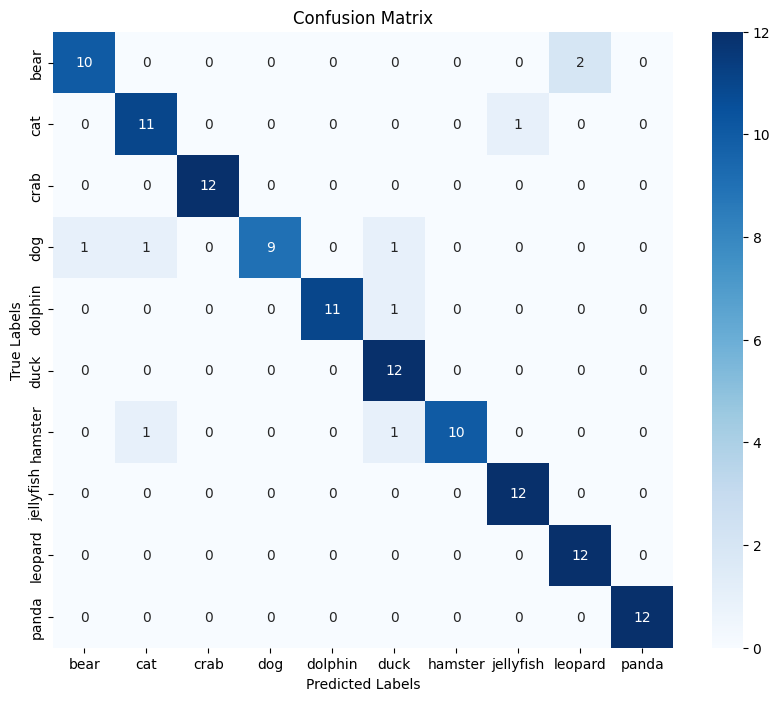

In [ ]:
# Compute the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Get the class labels
class_labels = label_encoder.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Style-Transfer

Link to [Neural Style Transfer Notebook](https://colab.research.google.com/drive/1KxoVa37lpUKqiyMIGvZfso1NaArhYm7W)
- Note that people could experiment more content images and style images by changing the paths to the images.
- The images used is in data/Style_tr

